# Data Mining Versuch Verkehrsschilderkennung mit Neuronalen Netzen

* Autor: Prof. Dr. Johannes Maucher
* Datum: 14.11.2019

# Einführung

In diesem Versuch soll ein Convolutional Neural Network (CNN) für die Erkennung von Verkehrschildern implementiert, trainiert, evaluiert und getestet werden. Als Eingabe erhält das neuronale Netz Bilder von deutschen Verkehrsschildern. Ausgabe ist der Typ des Verkehrsschilds. Für Training und Test sind die Verkehrsschildbilder schon in separate Verzeichnissen abgelegt. Neben den Bildern selbst, enthält das zu diesem Versuch gehörende Datenverzeichnis auch Dateien mit Metadaten, die z.B. Bildeigenschaften, Verkehrsschildbedeutungen und die zugehörigen Klassenlabel beschreiben.

## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Convolutional Neural Networks (CNNs)
* Implementierung Tiefer Neuronaler Netze mit Tensorflow und Keras: 
    - Definition der Netzarchitektur
    - Training
    - Evaluation und Test
    
* Einfache Methoden der Bildverarbeitung:
    - Augmentierung
    - Kontrastverstärkung

* Evaluation eines Klassifikators


## Vorbereitung

### Grundlagen Neuronale Netze
Machen Sie sich mit den [Grundlagen herkömmlicher Neuronaler Netze (KI Vorlesung)](https://gitlab.mi.hdm-stuttgart.de/maucher/KI/blob/master/Slides/09_PartLernen4.pdf) und den [Grundlagen Convolutional Neural Networks ((KI Vorlesung))](https://gitlab.mi.hdm-stuttgart.de/maucher/KI/blob/master/Slides/V11DeepLearningKIversion.pdf) vertraut.


### Implementierung Neuronaler Netze mit Tensorflow und Keras
Machen Sie sich mit der Implementierung von Neuronalen Netzen mit Tensorflow und Keras vertraut. Z.B. mit den [Tensorflow Quickstart Tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner)

# Durchführung

## Vorbereitende Untersuchungen
1. Importieren Sie ein Bild aus dem Verzeichnis `Train` mit der [scikit-image.io](https://scikit-image.org/docs/dev/api/skimage.io.html)-Methode `imread()` und zeigen Sie dieses mit der Methode `imshow()` an. Geben Sie die Größe des Bildes aus (Attribut `.shape`). 
2. Verändern Sie die Größe des Bildes mit der [scikit-image.transform](https://scikit-image.org/docs/dev/api/skimage.transform.html)-Methode `resize()` auf eine Größe von $32x32x3$. Die Verzerrung des Seitenverhältnisses kann dabei ignoriert werden.
3. Führen Sie mit der [scikit-image.exposure](https://scikit-image.org/docs/dev/api/skimage.exposure.html)-Methode `equalize_adapthist()` eine Kontrastverstärkung des Bildes durch. Zeigen Sie das vergrößerte und kontrastangereicherte Bild an. **Anmerkung:** Das kontrastverstärkte Bild sieht zwar unschöner aus, auf der Basis kontrastverstärkter Bilder läßt sich aber im allgemeinen die Objekterkennung verbessern.
2. Importieren Sie die Datei `Train.csv` und machen Sie sich mit deren Inhalt vertraut. Die Datei `Test.csv` ist gleich strukturiert, bezieht sich aber auf die Bilder im Verzeichnis `Test`. Wieviele Zeilen enthalten die Dateien?
3. Importieren Sie die Datei `signnames.csv` und machen Sie sich mit deren Inhalt vertraut. 

In [1]:
import multiprocessing
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from keras_preprocessing.image import ImageDataGenerator
from pandas import DataFrame
from skimage import io, transform, exposure
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras import Sequential
from tensorflow.keras import models
from tensorflow.python.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import json

Zuerst wird eine Funktion definiert, die Bilder aus der gegebenen Ordnerstruktur laedt.
Um nicht alle Bilder auf einmal zu laden, kann ein Limit eingestellt werden.
Die Bilder werden dabei unstrukturiert in einer Liste zurueckgegeben, da die Struktur fuer
die relevanten Data-Exploration-Tasks erst einmal nicht von Bedeutung ist.

In [2]:
def load_images_from_class_folders(class_folder_dir, image_limit=None):
    classes = [directory for directory in os.listdir(class_folder_dir) if
               os.path.isdir(os.path.join(class_folder_dir, directory))]
    train_images = [x for class_name in classes for x in
                    [io.imread(os.path.join(".", class_folder_dir, class_name, file))
                     for file in os.listdir(os.path.join(".", class_folder_dir, class_name))[
                                 :image_limit if image_limit else -1]]]
    return train_images


train_images = load_images_from_class_folders(os.path.join(".", "data/Train"), image_limit=10)
len(train_images)

430

Um einen Ueberblick darueber zu bekommen, wie ein Bild in Datenform aussieht, wird eines dieser
Bilder nun ausgegeben.

In [3]:
image = train_images[0]
image.shape

(27, 27, 3)

Wie man gut erkennen kann, hat das Bild die Dimensionen 27x27 Pixel und 3 Kanaele
pro Pixel. Somit handelt es sich eindeutig um ein RGB-Bild.

Dieses RGB-Bild wird nun einmal als solches angezeigt, um ein Verstaendnis davon zu erhalten,
was in solch einem Bild repraesentiert wird.

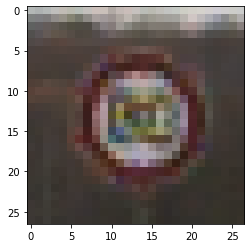

In [4]:
plt.imshow(image)

Es sich um ein relativ kleines Bild (27x27 Pixel) handelt, ist in diesem Falle auch fuer den Menschen schwer zu
erkennen, um was fuer ein Verkehrszeichen es sich handelt. Im Verlaufe des Versuchs wird sich zeigen,
ob eine Maschine dies besser hinbekommt.

Um die Groessenverteilung der Bilder anzuschauen, werden diese in einem Boxplot ausgegeben.

<AxesSubplot:>

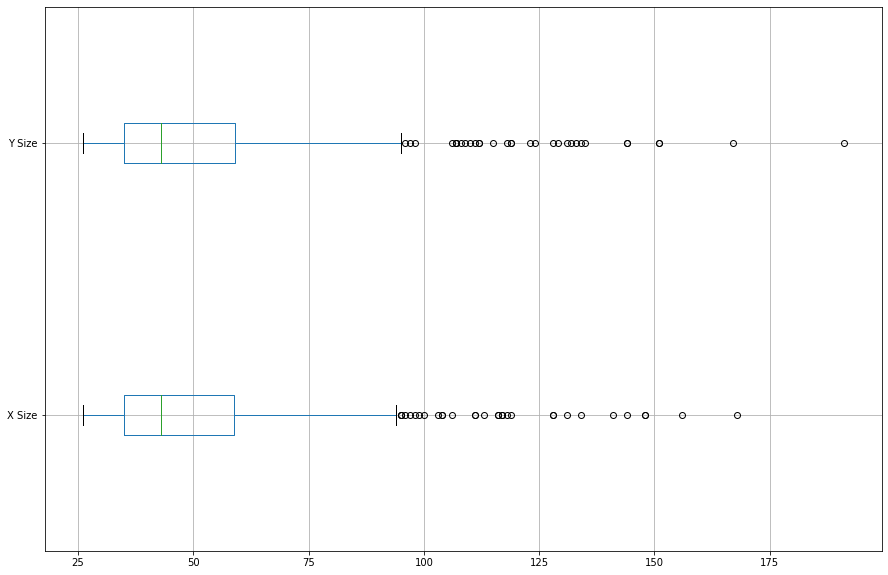

In [5]:
image_sizes = DataFrame([list(image.shape) for image in train_images], columns=["X Size", "Y Size", "Num Channels"])
image_sizes.iloc[:, :2].boxplot(vert=False, figsize=(15, 10))

Wie man gut erkennen kann, sind die meisten Bilder etwa zwischen 25 und 100 Pixel breit
sowie hoch. Es gibt ein paar Ausreisser nach oben, bis hin zu 190 Pixel in der Breite und
170 Pixel in der Hoehe.

Um diese, doch sehr verschieden große, Bilder auf eine Einheitsgroeße zu bringen, wird nun eine
Funktion implementiert, welche ein gegebenes Bild in Form eines Numpy-Arrays auf eine gegebene
Groeße skaliert.

Die einheitliche Zielgroeße soll hier 32 auf 32 Pixel betragen.

In den meisten Faellen ist 32x32 Pixel kleiner als das Ausgangsbild, beim aktuellen Beispiel-Bild
hingegeben bedeutet dies eine Skalierung auf eine Groesse die groesser als die aktuelle ist.
Um hier moeglichst wenig Informationen ueber den Inhalt des Bildes verloren gehen, wird eine Bi-Quintic
Interpolationsmethode verwendet. Normalerweise waere in diesem Fall die NearesT-Neighbour-Methode die Beste,
da sie die eigentlichen Pixelwerte nicht veraendert, jedoch fuehrt sie in diesem Fall zu großen Verzerrungen bei kleinen Bildern.

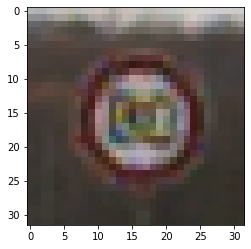

In [6]:
def resize_image(image, shape):
    new_image = transform.resize(image, shape, order=5)
    return new_image


resized_image = resize_image(image, (32, 32))
plt.imshow(resized_image)

Wie gut zu erkennen ist, wird der Inhalt des Bildes beim Skalieren leicht geglaettet,
allerdings haelt sich die Verzerrung in Grenzen, sodass das Ergebnis fuer das Training und Testen
eines neuronalen Netzes genutzt werden kann.

Um die relevanten Inhalt eines solchen Bildes noch einmal hervorzuheben, wird eine
Histogram-Angleichung vorgenommen. Diese erhoeht den Kontrast im Bild, sodass die Zeichen innerhalb
eines Schildes besser vom Rest des Schildes, und das Schild besser von seiner Umgebung unterschieden
werden kann.

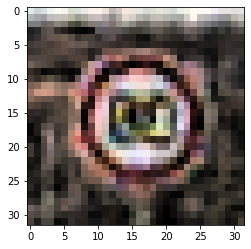

In [7]:
def adaptive_histrogram_equalization(image, kernel_size):
    new_image = exposure.equalize_adapthist(image, kernel_size)
    return new_image


contrast_image = adaptive_histrogram_equalization(resized_image, 5)
plt.imshow(contrast_image)

Wie gut erkennbar ist, ist das Schild selbst sowie der Inhalt des Schildes besser erkennbar.
Man kann ebenfalls mehr Details in der Umgebung erkennen, was fuer die blosse Erkennung zwar nicht
von Bedeutung ist, allerdings dadurch einen groessern Werteunterschied zum Schild darstellt, und somit
von einem Computer als unterschiedlich erkannt werden kann.

Jetzt werden die relevanten Metadaten in Form einer CSV in ein Pandas DataFrame eingelesen.

In [8]:
train_csv = pd.read_csv(os.path.join(".", "data", "Train.csv"))
print(f"Train.csv has {len(train_csv)} lines.")
train_csv.sample(frac=1).head(10)

Train.csv has 39209 lines.


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
32579,117,107,11,9,107,98,31,Train/31/00031_00016_00029.png
30392,52,47,5,5,47,42,26,Train/26/00026_00014_00002.png
15130,35,35,6,5,30,30,10,Train/10/00010_00003_00010.png
7050,28,29,5,6,23,24,4,Train/4/00004_00020_00000.png
11490,25,27,5,6,20,21,7,Train/7/00007_00026_00000.png
13441,28,28,6,6,23,23,8,Train/8/00008_00043_00001.png
8120,45,43,6,5,40,38,4,Train/4/00004_00055_00020.png
38426,80,80,7,7,72,72,40,Train/40/00040_00001_00027.png
28560,54,59,5,6,49,54,25,Train/25/00025_00003_00000.png
39054,42,44,5,5,37,39,42,Train/42/00042_00002_00025.png


In den Metadaten befinden sich einige Informationen, wie die Hoehe und Breite des Bildes, sowie die
sogenannte *region of interest*, also in diesem Fall der Bereich, in dem sich das eigentliche
Verkehrsschild befindet. Desweitern is die *ClassId*, also der Type des Schildes, sowie der Pfad im
Trainingsverzeichnis angegeben.

In [9]:
test_csv = pd.read_csv(os.path.join(".", "data", "Test.csv"))
print(f"Test.csv has {len(test_csv)} lines.")
test_csv.sample(frac=1).head(10)

Test.csv has 12630 lines.


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
3988,40,43,5,6,35,38,16,Test/03988.png
1783,31,31,5,5,26,26,10,Test/01783.png
2450,32,30,6,6,27,25,11,Test/02450.png
5422,49,49,5,6,44,44,31,Test/05422.png
4749,43,44,5,6,38,39,2,Test/04749.png
2198,49,49,5,5,44,44,12,Test/02198.png
8152,40,40,6,6,35,35,7,Test/08152.png
10477,38,36,5,5,33,31,18,Test/10477.png
3347,38,39,5,6,33,34,35,Test/03347.png
5124,57,58,5,6,52,53,12,Test/05124.png


Bei den Testdaten ist die Metadatenstruktur die Selbe.

Jetzt werden noch die Label fuer die jeweiligen *ClassIds* aus den Metadaten geladen.
Sie finden sich in der *signnames.csv*-Datei.

In [10]:
signnames_csv = pd.read_csv(os.path.join(".", "data", "signnames.csv"))
signnames_csv.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


Der Inhalt beschraenkt sich auf die jeweilige ID der Klasse, also die Verkehrsschildklasse,
sowie der Name des jeweiligen Schildes.

## Funktion für den Import aller Trainings- bzw. Testbilder
Schreiben Sie eine Funktion mit folgenden Eigenschaften:
* Der Funktion wird der Name der Datei übergeben, in welcher die Metadaten stehen, also entweder `Train.csv` oder `Test.csv`.
* Rückgabewerte der Funktion sind 
    * ein 4-dimensionales numpy-array, das alle Bilder des jeweiligen Verzeichnisses (Training oder Test) enthält.
    * ein 1-dimensionales numpy-array, das die Klassenlabel aller Bilder enthält.
* Die Bilder müssen alle auf eine Größe von $32x32x3$ skaliert werden (wie in der Vorbereitungsaufgabe).
* Für alle Bilder ist eine Kontrastverstärkung durchzuführen (wie in der Vorbereitungsaufgabe).

**Tipps für die Implementierung dieser Funktion:**

Iterieren Sie mit einer for-Schleife über alle Zeilen des metadaten-Files. Pro Iteration kann dann 
* der vollständige Verzeichnis- und Filenamen ausgelesen werden,
* das entsprechende Bild mit `imread()` eingelesen werden,
* das Bild auf die vorgegebene Größe angepasst werden,
* der Kontrast des Bildes verstärkt werden.

**Wichtig:** In den von der Funktion zurückgegebenen Arrays, dürfen die Bilder nicht wie in der ursprünglichen Reihenfolge im Dateiverzeichnis enthalten sein. Um sicherzustellen, dass beim Training jedes Minibatch möglichst viele verschiedene Klassen enthält, muss die Reihenfolge geshuffelt werden. Am einfachsten ist es, wenn gleich die Zeilen des Metadatenfiles geshuffelt werden.

Nun wird eine Funktion definiert, die mit einem gegebenen Metadaten-DataFrame ein Datensatz
bestehend aus den eigentlichen Daten, also die Eingabedaten, sowie den Klassenlabels der Ausgabe erstellt.

Die Funktion kann in vielerlei hinsicht angepasst werden. Je nachdem, ob die eingebaut shuffle-Funktion
in des *keras*-Generators genutzt wird, koennen die Daten schon vor dem Laden zufaellig gemischt werden.
Zusaetzlich dazu kann dynamisches Laden eines eigenen Generators genutzt werden, bei dem jeweils nur ein
Teil der Daten auf einmal geladen wird, wofuer das *img_limit* sowie der *offset* benoetigt wird.
Desweiteren kann die Groesse der Bilder angegeben werden.

Da das Laden der Bilder sehr lange dauern kann, wurde dies, sowie alle Bildmanipulationen parallelisiert,
und nutzen so das volle Potenzial des Rechners, respektive der Festplatte.

In [11]:
def create_dataset(metadata, image_shape=(32, 32), offset=0, img_limit=-1, shuffle=True):
    thread_count = multiprocessing.cpu_count() * 2 + 1
    metadata_shuffled = metadata.sample(frac=1) if shuffle else metadata
    index_start = offset if offset != 0 else None
    index_end = offset + img_limit if img_limit != -1 else None
    images = np.array([io.imread(os.path.join(".", "data", path))
                       for path in metadata_shuffled["Path"][
                                   index_start: index_end]])
    images_resized = np.array(
        Parallel(n_jobs=thread_count)(delayed(resize_image)(image, image_shape) for image in images))

    # divide by max to avoid issue of weird float behaviour (1 value saved as 1.000000004)
    images_resized = images_resized / images_resized.max()
    images_contrast = np.array(
        Parallel(n_jobs=thread_count)(delayed(adaptive_histrogram_equalization)(x, 5) for x in images_resized))
    return images_contrast, np.array(
        metadata_shuffled["ClassId"][index_start: index_end])



Nun wird ein kleiner Testdatensatz mithilfe der vorherigen Funktion geladen und
ueber Richtigkeit geprueft und es wird ein Bild aus diesem Datensatz angezeigt.

<ipython-input-11-d73fcbd616b7>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images = np.array([io.imread(os.path.join(".", "data", path))


x-Shape: (100, 32, 32, 3)
y-Shape: (100,)


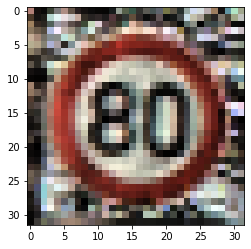

In [12]:
dataset_temp = create_dataset(train_csv, img_limit=100)
assert dataset_temp[0].shape[0] == 100
print(f"x-Shape: {dataset_temp[0].shape}")
print(f"y-Shape: {dataset_temp[1].shape}")
plt.imshow(dataset_temp[0][0])
plt.show()

Wie man erkennen kann, hat der Datensatz die gewunschte Laenge und alle Bilder haben
die gewuenschte Groesse.
Ebenfalls sind die Bilder waehrend der Verarbeitung nicht korrumpiert worden, koennen also
nach wie vor als Bilder angezeigt werden.

## Laden und Vorverarbeiten der Trainings- und Testdaten
1. Laden Sie mit der in der vorigen Teilaufgabe implementierten Funktion alle Trainingsbilder (`trainX`), Trainingslabel (`trainY`), Testbilder (`testX`) und Testlabel (`testY`)
1. Bestimmen Sie die Häufigkeitsverteilung der Klassen in den Trainings- und Testdaten. Visualisieren Sie diese.
2. Die Pixelwerte aller Bilder sind Integer zwischen 0 und 255. Transformieren Sie Trainings- und Testbilder so, dass die Werte Floats im Bereich zwischen 0 und 1 sind. Hierfür kann das gesamte 4-dimensionale Array durch 255 geteilt werden.
3. Alle Labels, sowohl der Trainings- als auch der Testdaten müssen One-Hot-encodiert werden.

Nun werden die Test- und Trainingsdaten mit der vorig geladenen Metadatenliste geladen.
Desweiteren werden die Klassen-Name, also die Namen der verschiedenen Schilder aus der
dementsprechenden CSV-Liste geladen.

In [13]:
train_x, train_y_raw = create_dataset(train_csv)
test_x, test_y_raw = create_dataset(test_csv)

<ipython-input-11-d73fcbd616b7>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images = np.array([io.imread(os.path.join(".", "data", path))


In [14]:
class_ids = list(signnames_csv["ClassId"])
classes = list(signnames_csv["SignName"])

Um die geladenen Daten auf Richtigkeit zu ueberpruefen, wird die Form der entstandenen
*numpy*-Arrays ausgegeben. Sie sollten die selbe Laenge wie die Metadatenlisten haben.

In [15]:
assert train_x.shape[0] == len(train_csv) == train_y_raw.shape[0]
assert test_y_raw.shape[0] == len(test_csv) == test_y_raw.shape[0]
print(train_x.shape, train_y_raw.shape)
print(test_x.shape, test_y_raw.shape)

(39209, 32, 32, 3) (39209,)
(12630, 32, 32, 3) (12630,)


Wie zu erkennen ist, stimmen die Laengen der Datensaetze mit den Quelldaten ueberein.

Um nun sicherzustellen, dass die Trainings- und Testdaten ueberhaupt eine sinnvolle Basis fuer
das Training eines neuronalen Netzes darstellen, wird nun die Verteilung der Werte ueber den
Trainings- und den Testdatensatz ermittelt.

<AxesSubplot:>

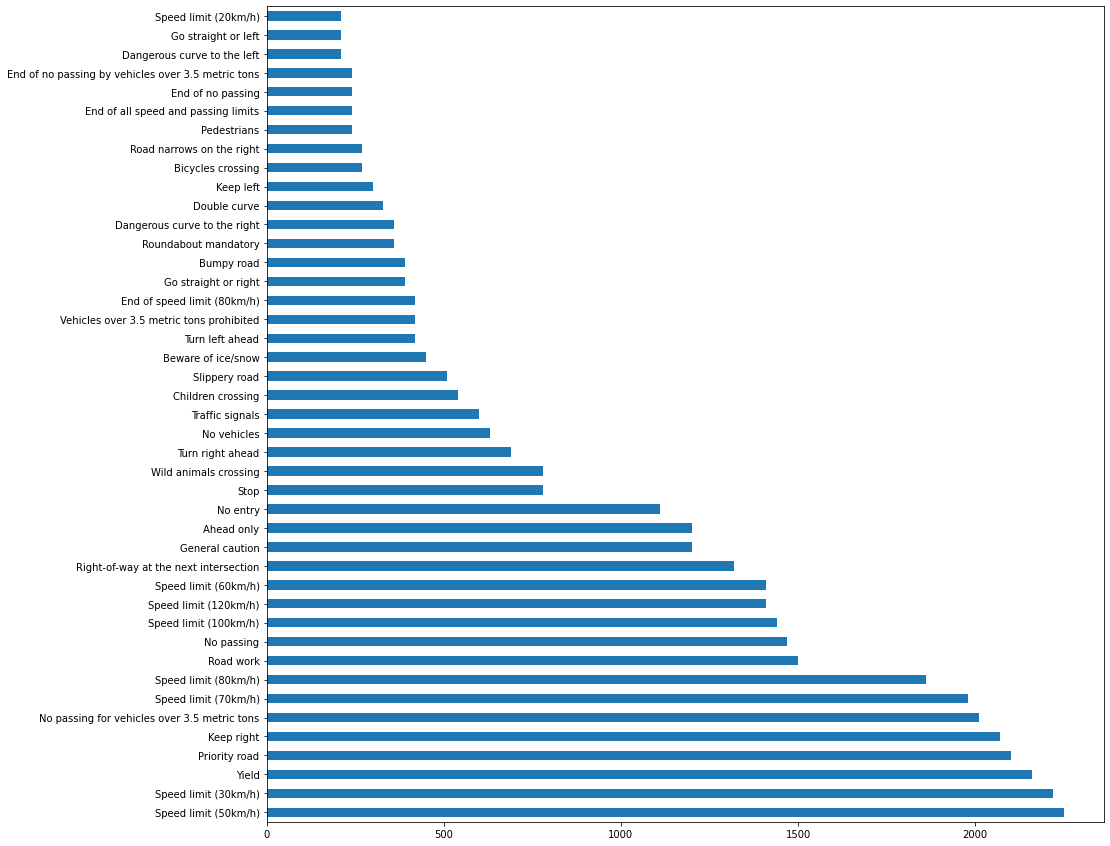

In [16]:
dist_train = DataFrame(train_y_raw).merge(
    DataFrame(classes, columns=["Sign Name"]), left_on=0, right_index=True)["Sign Name"].value_counts()
dist_test = DataFrame(test_y_raw).merge(
    DataFrame(classes, columns=["Sign Name"]), left_on=0, right_index=True)["Sign Name"].value_counts()

dist_train.plot.barh(figsize=(15, 15))

<AxesSubplot:>

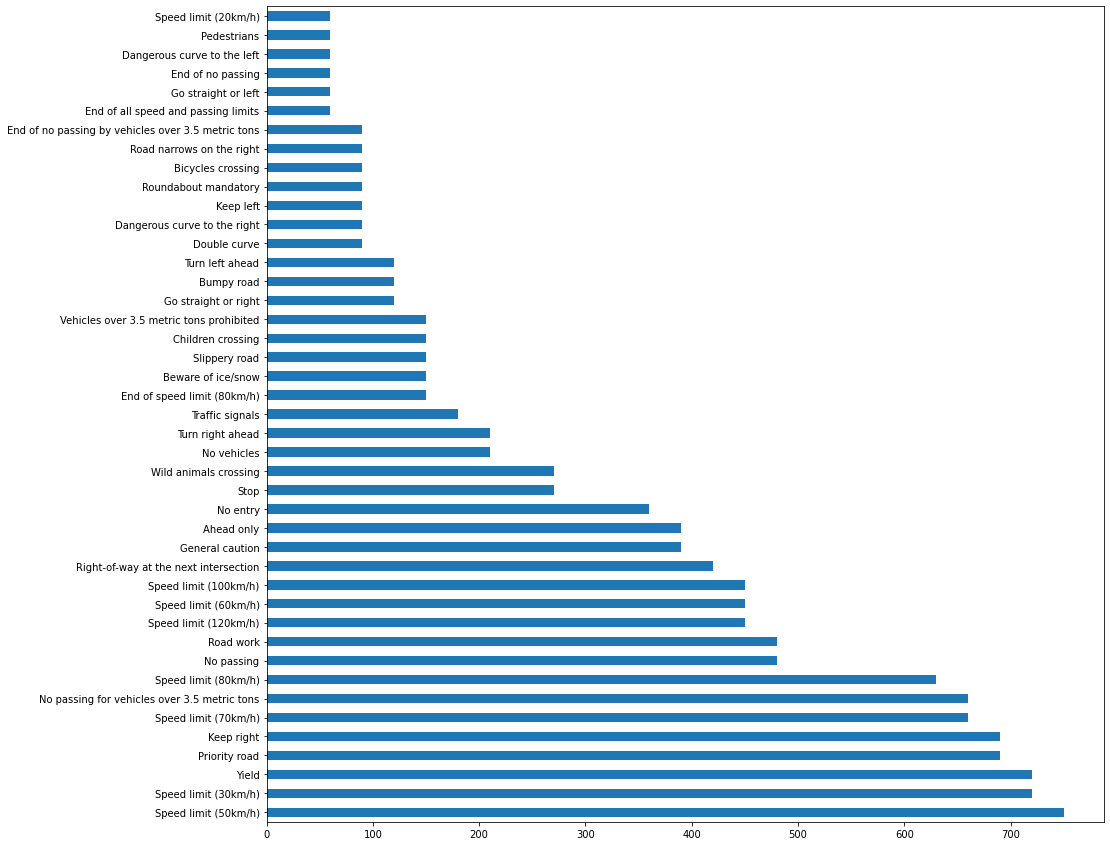

In [17]:
dist_test.plot.barh(figsize=(15, 15))

In [18]:
dist_differences = [(dist_train.loc[index] - dist_test.loc[index]) / len(train_y_raw) for index in dist_train.index]
print(
    f"Max percentage difference between test and train data distributions: "
    f"{round(max(dist_differences), 4) * 100}%")

Max percentage difference between test and train data distributions: 3.83%


Wie klar deutlich wird, sind die Unterschiede zwischen den Werteverteilungen im Trainings-
und Testdatensatz maximal bei 3.83%, was eine akzeptable Abweichung ist.

Nun werden die geladenen Labels fuer die Trainings- und Testdaten One-Hot-Enkodiert.
Dies bedeutet, dass jedes Label in die Form eines Arrays mit der Laenge der Liste aller Klassen
ersetzt wird, bei dem alle Werte auf 0 gesetzt werden und nur der Wert mit dem Index der Klassen-ID
auf 1 gesetzt wird.

Grund dafuer ist die Struktur eine tiefen neuronalen Netzes, wessen Ausgabe-Ebene ein Neuron fuer
jede Klasse hat, bei dem, im Idealfall, alle Ausgabewerte bei 0 liegen, bis auf den, wessen Index die
ID der vorhergesagten Klasse ist. Um diese Struktur zu antizipieren, muessen die Ausgabewerte
so kodiert werden.

In [19]:
encoder = OneHotEncoder(sparse=False)
train_y = encoder.fit_transform(train_y_raw.reshape((-1, 1)))
test_y = encoder.fit_transform(test_y_raw.reshape((-1, 1)))
train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Wie in der Ausgabe zu erkennen ist, hat das Kodieren funktioniert.

Um die Richtigkeit der Kodierung zu ueberprufen, wird nun der Index eines Items der Labels mit dem
urspruenglichen Label verglichen.

In [20]:
assert np.where(train_y[0] == 1) == train_y_raw[0]

Da kein Fehler entsteht, ist das Kodieren auch korrekt.

## Definition der CNN Architektur
Schreiben Sie eine Funktion `generateCNN(width, height, depth, classes)` die eine Keras CNN-Architektur zurück gibt. Für die Definition der Architektur werden dieser Funktion die Parameter:

* `width`: Breite der Bilder
* `height`: Höhe der Bilder
* `depth`: Anzahl der Kanäle pro Bild
* `classes`: Anzahl der unterschiedlichen Klassen

übergeben. Die in der Funktion zu implementierende Architektur ist im folgenden Bild dargestellt. In der Spalte *Output shape* bezeichnen die zweite und dritte Zahl die Breite und die Höhe der einzelnen Kanäle (*Bilder*), der letzte Parameter bezeichnet die Anzahl der Kanäle (Parameter *filters* in der Konfiguration).
In der Übersichtstabelle ist Filtergröße nicht aufgeführt. Empfohlen sind folgende Größen:
* für alle Pooling Layer: *pool_size=(2,2)*.
* für den ersten Conv2D-Layer: *kernel_size=(5,5)*.
* für alle weiteren Conv2D-Layer: *kernel_size=(3,3)*

**Anmerkung:** Der in der Tabelle mit *flatten_5* bezeichnete Layer ist nicht notwendig und erzeugt in bestimmten Keras-Versionen eine Fehlermeldung. Der Layer sollte nicht nicht in die Architektur mit aufgenommen werden.


<img src="https://maucher.home.hdm-stuttgart.de/Pics/cnnTrafficSign.png" style="width:700px" align="middle">

Jetzt wird das zu trainierende Modell generiert.

Hierzu wird eine Funktion implementiert, welche ein sequentielles Modell equivalent
zu der gegebenen Ausgabe eines Modells erstellt.

Als Aktivierungsfunktion wird die allgemein verwendete *relu*-Funktion verwendet.
Die Dropout-Rate wurde auf 0.25 gesetzt.
Die initiale Filtergroesse, sowie alle Multiplikationen jener waren bereits gegeben.

Wichtig hierbei ist, als letzte Aktivierungsfunktion die *softmax*-Funktion zu verwenden, damit
die Ausgabewerte in der vorletzen Ebene in eine Wahrscheinlichkeitsverteilung in der letzen Ebene
umgerechnet wird, bei der alle Werte zu 1 summieren.

In [21]:
def genertate_cnn(width, heigth, depth, classes):
    filter_size = 8
    activation = "relu"
    dropout_rate = 0.25

    model = Sequential()

    model.add(Conv2D(filter_size, kernel_size=(5, 5),
                     input_shape=(width, heigth, depth), padding="same"))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filter_size * 2, kernel_size=(3, 3), padding="same"))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())

    model.add(Conv2D(filter_size * 2, kernel_size=(3, 3), padding="same"))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filter_size * 4, kernel_size=(3, 3), padding="same"))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())

    model.add(Conv2D(filter_size * 4, kernel_size=(3, 3), padding="same"))
    model.add(Activation(activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, use_bias=False))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))
    model.add(Dense(128))
    model.add(Activation(activation=activation))
    model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))
    model.add(Dense(len(classes)))
    model.add(Activation(activation="softmax"))

    return model

## Training des CNN
Rufen Sie die im vorigen Abschnitt implementierte Funktion `generateCNN()` auf und weisen Sie die von der Funktion zurückgegebene Architektur der Variablen `model` zu. Durch Aufruf der Funktion `model.summary()` erhalten Sie eine Übersicht des erzeugten Netzes.

Für das Training soll der `Adam`-Algorithmus aus dem Modul `tensorflow.keras.optimizers` benutzt werden. `Adam` implementiert ein *Stochastic Gradient Descent*-Lernverfahren, welches die Lernraten für die Gewichte individuell und dynamisch anpasst.

Um das Training nicht bei jedem Ausfuehren des Notebooks erneut durchfuehren zu muessen,
wird eine Speicher- sowie Ladefunktion fuer das generierte und trainierte Modell implementiert.

Damit kann das Modell, sowie die Trainingshistorie persistent abgespeichert werden.

In [22]:
def save_model(model, hist, path):
    model.save(path)
    with open(path + "_hist", "w") as hist_file:
        hist_file.write(json.dumps(hist))

In [23]:
def load_model(path):
    model = models.load_model(path)
    with open(path + "_hist", "r") as hist_file:
        hist = json.load(hist_file)
    return model, hist

Nun wird ein Modell mit der vorherig implementierten Funktion generiert, oder, falls bereits
ein Modell trainiert wurde, dieses von der Festplatte geladen.

Anschliessen wird eine Zusammenfassung des Modells ausgegeben.

In [24]:
model_name = "custom_adam"
if os.path.isdir(os.path.join(".", model_name)):
    model, hist = load_model(os.path.join(".", model_name))
else:
    model = genertate_cnn(32, 32, 3, classes)
    hist = None

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

Nun werden wichtige Trainingsparameter definiert.

In [25]:
NUM_EPOCHS = 15  # Number of training epochs
INIT_LR = 1e-3  # Initial Learning Rate for ADAM training
BS = 64  # Size of minibatches

Nun wird der *Adam-Optimizer* initialisiert, und das Modell damit compiliert, sodass es
trainiert werden kann.

In [26]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/home/alex/projects/mi-lab-ss21/ml_lab/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Für das Training sollen nicht nur die vorhandenen Trainingsbilder eingesetzt werden, sondern zusätzlich Bilder die Augmentierungen der Trainingsbilder sind. Augmentierte Bilder können mit dem `ImageDataGenerator` des Moduls `tensorflow.keras.preprocessing.image` erzeugt werden. Der Code für die Erzeugung des in diesem Projekt eingesetzten Objekts ist unten gegeben. 

**Aufgabe:** Erklären Sie was in dieser Codezelle definiert wird.

Um mehr Varianz in den Trainingsdaten zu erzeugen, koennen, vor allem bei Bildern,
gewissen Funktionalitaeten verwendet werden, die solch eine Varianz induzieren.

Eine Moeglichkeit dafuer ist der ImageDataGenerator. Dieser kann zum einen ein Datensatz
*lazy laden*, also immer nur das jeweilig benoetigte Batch and Bilder laden, zum Anderen
gibt er die Moeglichkeit, Varianz mit gegebenen Parametern in den Datensatz zu bringen.

Varianz ist in diesem Falle leichte Modifikationen der geladenen Bilder. Dies kann die
Form von Rotation, Vergroesserung, Verschiebung oder Abschneiden von Bildteilen haben.

Wichtig hierbei ist der letzte Parameter, welcher definiert, dass die Interpolationsmethode
*nearest Neighbour* verwendet wird. Grund dafuer ist, wie auch schon beim skalieren der Bilder, dass
durch Glättung beim Skalieren keine Verzerrungen des Bildinhaltes entstehen.

In [27]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

Das Training wird mit folgender Codezelle ausgeführt.

**Aufgabe:** Erklären Sie die Argumente der Funktion `fit_generator()`. 

Für die Ausführung der Zelle muss das numpy-Array `classWeight` angelegt sein. Sie enthält für jede Klasse den relativen Anteil dieser Klasse in den Trainingsbildern. Wenn z.B. 30% aller Trainingsdaten zur Klasse 0 gehören, dann hätte das erste Element in `classWeight` den Wert 0.3.

Um die Gewichtung der Klassen, also die Verteilung der jeweiligen Klassen im gesamten Datensatz zu beruecksichtigen,
muss diese angegeben werden. Die Klassengewichtung muss in Form eines Dictionaries mit den jeweiligen
Klassen-IDs als Keys und der Verteilung als Values angegeben werden.
Dieses Dictionary wird im Folgenden generiert.

In [28]:
class_weight = {i: dist_train.loc[class_name] / len(train_y) for i, class_name in enumerate(classes)}
DataFrame.from_dict(class_weight, orient="index", columns=["Class weight"]).head(5)

,Class weight
0,0.005356
1,0.056620
2,0.057385
3,0.035961
4,0.050499


Da das Training von neuronalen Netzen sehr gut parallelisiert werden kann, und eine GPU
hervorragende Moeglichkeiten zur Parallelisierung bietet, kann *tensorflow* GPUs zum trainieren
verwenden. Um zu ueberpruefen, ob sich eine kompatible GPU im System befindet, dient die folgende
Zeile.

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Nun wird das Modell, falls noch nicht geschehen, mit dem vorher initialisierten
*ImageDataGenerator* trainiert. Die *fit_generator*-Methode ist mittlerweile *deprecated* und wurde
deshalb durch die allgemeinere *fit*-Methode ersetzt. Diese trainiert das gegebene Modell mit den
gegebenen Trainingsdaten. Fuer die Validierung des Trainings, und die Live-Anzeige der Performance
werden die sogenannten Validierungsdaten verwendet. In der Regel sind diese Daten noch ungesehene Date,
also weder in den Test, noch in den Trainingsdaten enthalten, aber fuer die Einfachheit des Versuches
kann davon abgesehen werden, weshabld dafuer die Testdaten verwendet werden.

Mit Generatoren wird immer in kleinen Batches trainiert. Diese *Batch-Size* wurde bereits
definiert. Wichtig hierbei is, dass klar definiert wird, dass es jeweils nur so viele Schritte in einer Epoche
gibt, wie es Batches in dem Datensatz gibt.
Desweiteren muss die Anzahl an Epochen definiert werden. Dies ist ein experimenteller Wert,
welcher im beste Fall der ideale Wert zwischen over- und underfitting ist. Hier wurde
erst einmal 15 gegeben. Dieser Wert wird spaeter noch in Frage gestellt.

Um die Ausgabe von Fortschrittsinformationen, sowie der aktuellen Performance
zu erreichen, muss der *verbose*-Parameter gesetzt werden. 1 ist in diesem Fall ausreichend.

Um auf die Historie des Trainings zugreifen zu koenen, muss sie in einer Variable gespeichert werden.
Auf diese Historie kann mit *.history* zugegriffen werden.

In [30]:
# compile the model and train the network
print("[INFO] training network...")

if not hist:
    hist = model.fit(
        aug.flow(train_x, train_y, batch_size=BS),
        validation_data=(test_x, test_y),
        steps_per_epoch=train_x.shape[0] // BS,
        epochs=NUM_EPOCHS,
        class_weight=class_weight,
        verbose=1).history

[INFO] training network...


Um das Training nicht immer wiederholen zu muessen, wird das trainierte Modell
direkt persistent auf der Festplatte gespeichert.

In [31]:
save_model(model, hist, os.path.join(".", model_name))

INFO:tensorflow:Assets written to: ./custom_adam/assets


Visualisieren Sie die Entwicklung der *Accuracy* über dem Fortschritt der Trainingsepochen. Plotten Sie dabei die entsprechenden Kurven der Accuracy auf den Trainings- und auf den Testdaten in einen Graphen.

Nun wird die Trainings-Historie in einem Plot angezeigt.

<AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>

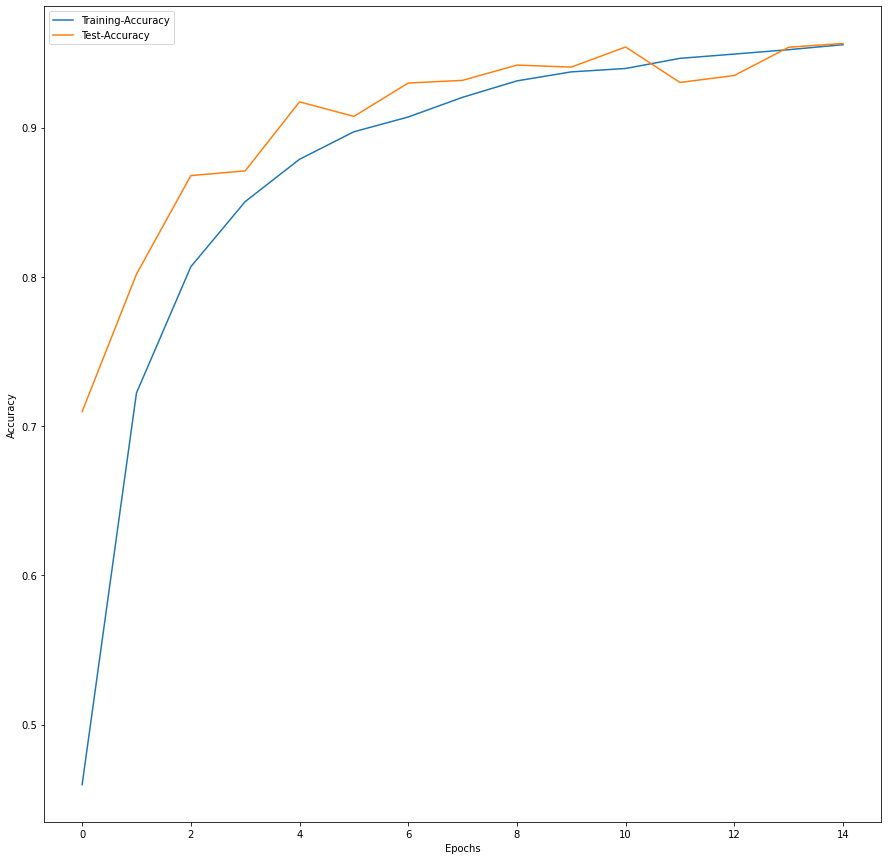

In [32]:
acc_hist = DataFrame(list(zip(hist["accuracy"], hist["val_accuracy"])),
                     columns=["Training-Accuracy", "Test-Accuracy"])
acc_hist.plot(figsize=(15, 15), xlabel="Epochs", ylabel="Accuracy")

Wie gut erkennbar ist, steigt die Accuracy auf den Trainingsdaten, also die blaue Kurve,
schnell an.
Die Kurve ist logarithmisch und naehert sich der 1.0, also der 100% an.

Was deutlich wird, ist dass die orangene Kurve, also die Accuracy der Testdaten
sicher immer nahe der Accuracy der Trainingsdaten befindet. In den ersten
Epochen ist sie sogar hoeher, und naehert sich gegeben Ende der 15 Epochen and die
Accuracy der Trainingsdaten an.

Beide Kurven zeigen in der letzten Epoche noch eine positive Steigung, was bedeutet,
dass mehr Epochen noch mehr Accuracy bedeuten koennte.

Um diese Performance mit einem Modell zu vergleichen, was laenger trainiert wurde,
wird nun ein Modell mit 30 Epochen trainiert.

In [33]:
model_name_30 = "custom_adam_30"

if os.path.isdir(os.path.join(".", model_name_30)):
    model_30, hist_30 = load_model(os.path.join(".", model_name_30))
else:
    model_30 = genertate_cnn(32, 32, 3, classes)
    hist_30 = None

if not hist_30:
    opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
    model_30.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    hist_30 = model_30.fit(
        aug.flow(train_x, train_y, batch_size=BS),
        validation_data=(test_x, test_y),
        steps_per_epoch=train_x.shape[0] // BS,
        epochs=30,
        class_weight=class_weight,
        verbose=1).history

    save_model(model_30, hist_30, os.path.join(".", model_name_30))

<AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>

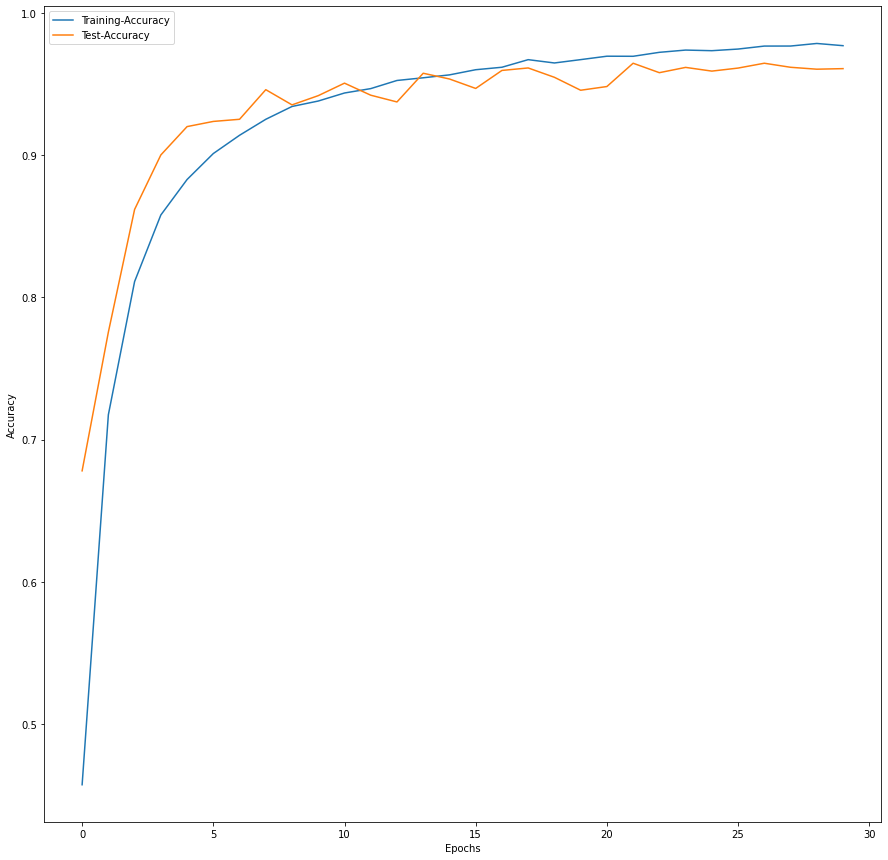

In [34]:

acc_hist_30 = DataFrame(list(zip(hist_30["accuracy"], hist_30["val_accuracy"])),
                        columns=["Training-Accuracy", "Test-Accuracy"])
acc_hist_30.plot(figsize=(15, 15), xlabel="Epochs", ylabel="Accuracy")

Wie deutlich wird, ist die Accuracy noch einmal gestiegen. Die Accuracy auf den
Trainingsdaten steigt kontinuierlich weiter an, was allerdings auf die Natur eines solchen Trainingsverfahrens zurueckzufuehren ist. Es gibt auf den
Testdaten mehr Varianz bezüglich der Accuracy. Schon ab Epoche 15 steigt sie nur noch
marginal an. Dies bedeutet, dass die 15 extra Epochen nur noch wenig Verbesserung
bringen, also nicht unbedingt den zusaetzlichen Rechenaufwand rechtfertigen, sind also
nur sinnvoll, wenn jeder Prozent Accuracy im fertigen Modell notwendig ist.

Allerdings bedeuten mehr Epochen auch die Gefahr des Overfittings. Da die Accuracy
auf den Testdaten allerdings **noch** nicht sinkt, ist dieser Punkt noch nicht erreicht.

## Evaluation des gelernten Modells

Wenden Sie das gelernte CNN an, um für alle Bilder des Testdatensatzes die Art des Verkehrsschildes zu bestimmen. Evaluieren Sie die Qualität des CNN indem Sie einen `classification_report()` aus dem Modul `sklearn.metrics` erzeugen. 

1. Welche Metriken werden im Report angezeigt? Beschreiben Sie diese kurz?
2. Diskutieren Sie die Klassifikationsgenauigkeit des CNN anhand des Reports.

Zeigen Sie 5 Bilder an, die nicht korrekt klassifiziert wurden. Läßt sich die Fehlklassifikation erklären?

Zuerst werden die Predictions fuer die Testdaten erzeugt.
Dabei hilft die *numpy*-Funktion *argmax*. Diese gibt den Index des Maximalwertes in
einem Array zurueck.
Damit kann man zum einen die One-Hot-Kodierung rückgängig machen, und zum anderen
das Neuron mit dem hoechsten Ausgabewert des neuronalen Netzes, also die Prediction bekommen.


In [35]:
y_pred = np.argmax(model.predict(test_x), axis=1)
y_actual =  test_y_raw

Nun kann aus den Predictions ein Klassifikations-Report erstellt und ausgegeben werden.

In [36]:

report = classification_report(y_pred, y_actual)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        56
           1       0.99      0.98      0.98       724
           2       0.98      0.99      0.99       741
           3       0.95      0.97      0.96       439
           4       0.98      0.99      0.98       655
           5       0.95      0.97      0.96       620
           6       0.95      0.98      0.97       146
           7       0.98      0.94      0.96       465
           8       0.98      0.93      0.96       474
           9       0.99      0.93      0.96       509
          10       0.98      1.00      0.99       649
          11       0.97      0.82      0.89       496
          12       0.96      1.00      0.98       666
          13       1.00      0.99      1.00       723
          14       1.00      0.96      0.98       279
          15       0.97      0.89      0.92       229
          16       0.81      1.00      0.90       122
          17       0.96    

Ein Klassifikations-Report zeigt die Performance-Metriken **precision**, **recall** und **f1-score** an.

##### Precision
Die Rate an als X klassifizierten Items, die tatsaechlich der Klasse X angehoeren, also
die *true positives* geteilt durch die *true positives + false positives*.
Dieser Wert sollte maximiert werden, wenn es hohe Kosten fuer *false positives* gibt,
zum Beispiel bei einer Spam-Erkennung.

##### Recall
Die Rate an Items die der Klasse X angehoeren, die tatsaechlich als X klassifiziert wurden, also
die *true positives* geteilt durch die *true positives + false negatives*.
Dieser Wert sollte maximiert werden, wenn es hohe Kosten fuer *false negatives* gibt,
zum Beispiel bei einer Betrugserkennung einer Bank.

##### F1-Score
Der F1-Score kombiniert die Precision und den Recall in einem Wert.
Dieser Wert sollte maximiert werden, wenn man eine Balance aus Precision und Recall
moechte.

#### Performance des Modells

Im Report ist zu erkennen, dass eine gewichtete Precision sowie ein gewichteter Recall von
0.96 respektive 0.95, was fuer ein neuronales Netz ein durchaus hoher Wert ist.

Man kann erkennen, dass es teilweise hohe Unterschieden zwischen den verschiedenen Klassen gibt.
Vor allem die Klassen mit einer hohen Reprasentation, wie Klassen 1, 2, oder 38 haben hohe Werte,
waehrend Klassen mit weniger Trainings- respektive Testdaten, wie 0, 19 oder 42, eher geringere
Performance-Werte aufweisen.


Auffällig sind Klassen wir 33 und 34, welche eine Precision von 1.0 aufweisen, was bedeutet,
das alle die als Klasse 33 und 34 erkannt wurden aut tatsaechlich dieser Klasse angehoert haben.

Um zu verstehen, warum genau diese Klassen eine hohe Precision aufweisen, werden diese nun ausgegeben.

Turn right ahead, Turn left ahead


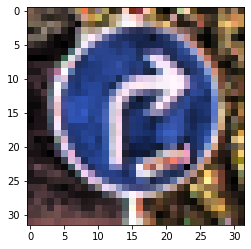

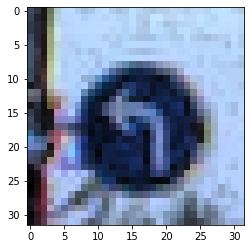

In [37]:
print(f"{classes[33]}, {classes[34]}")

example_33 = train_x[np.where(train_y_raw == 33)[0][0]]
plt.imshow(example_33)
plt.show()

example_34 = train_x[np.where(train_y_raw == 34)[0][0]]
plt.imshow(example_34)
plt.show()

Hohe Präzision gibt es bei den beiden Schildern mit Pfeilen nach links und rechts.
Dies laesst sich in sofern erklaeren, als dass diese beiden sehr unterschiedlich zum
Rest der Schilder sind. Sie haben nur einen soliden Pfeil in der Mitte, was sie vor allem von denen
mit Text oder Zahlen, wie Geschwindigkeitsbegrenzungen, unterscheidet. Desweiteren sind sie blau, was
sie ebenfalls relativ eindeutig macht, da fast keine Schilder blau sind. Damit koennte sich der Fakt
erklaeren lassen, dass es keine Schilder gibt, die faelschlicherweise als solche erkannt wurden.

Desweiteren gibt es auch die Variante mit Klasse 16 und 17, bei denen es einen Recall
von 1,0 gibt, was bedeutet, dass alle Schilder der Klasse 16 und 17 als solche erkannt wurden.

Vehicles over 3.5 metric tons prohibited, No entry


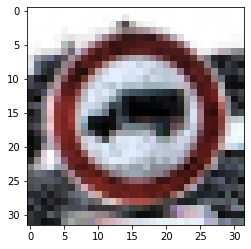

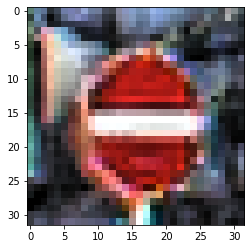

In [38]:
print(f"{classes[16]}, {classes[17]}")

example_16 = train_x[np.where(train_y_raw == 16)[0][0]]
plt.imshow(example_16)
plt.show()

example_17 = train_x[np.where(train_y_raw == 17)[0][0]]
plt.imshow(example_17)
plt.show()

Besonders hohen Recall gibt es also bei den Schildern *Vehicles over 3.5 metric tons prohibited* und
*No entry*. Dies koennte sich ebenso mit der Eindeutigkeit der Schilder erklaeren lassen.
Vor allem das *no entry* Schild ist ziemlich eindeutig. Im Straßenverkehr gibt es kein weiteres Schild
das die Kombination aus dieser Form und dieser Farbe hat.
Beim *Vehicles over 3.5 metric tons prohibited*-Schild waere die Vermutung, dass die Kombination aus roten
Rand sowie einem dunklen Fleck in der Mitte das Schild ebenfalls eindeutig macht, und es somit nicht so einfach
mit anderen verwechselbar ist. Damit koennte sich der Fakt erklaeren lassen, dass es keine Schilder dieser
Klasse gibt, die nicht als solche erkannt wurden.

##### Interpretation der Werte

Bei einer Verkehrszeichenerkennung wird eine maximale Precision wichtig sein, vor allem,
wenn andere Systeme, wie eine automatische Geschwindigkeitsregelung daran angeschlossen sind.
In solch einem Falle wird es wichtiger sein, dass ein Schild korrekt erkannt wird, als dass ein
Schild nicht erkannt wird.

Sollte der Einsatzzweck jedoch, zum Beispiel bei einer Fahrverhaltensanalyse liegen, sind falsche Positive
nicht so dramatisch.


Um einen Ueberblick zu bekommen, wie viele Predictions tatsaechlich falsch sind, wird
die Anzahl falscher Klassifikationen im Folgenden berechnet.

In [39]:
wrong_classification_indices = [i for i in range(len(y_pred)) if y_pred[i] != y_actual[i]]
wrong_classifications = np.take(test_x, wrong_classification_indices, axis=0)
wrong_classifications.shape

(575, 32, 32, 3)

Insgesamt wurden 575 Items aus den Testdaten inkorrekt klassifiziert. Das klingt nach viel, aber um die Zahl
in den Kontext zu bringen, solle sie mit den Gesamtanzahl verglichen werden.

In [40]:
print(f"Wrong classification percentage: {round(wrong_classifications.shape[0] / test_x.shape[0], 4) * 100}%")

Wrong classification percentage: 4.55%


Ueber alle Testdaten ergibt sich eine Fehlerrate von nur 4.55%, was einer Wahrscheinlichkeit fuer eine
korrekte Klassifikation fuer ein ungesehenes Verkehrsschild von 95.45% entspricht.

Diese Zahl kann hoechst wahrscheinlich durch weitere Modifikationen oder Erweiterungen des Netzes, sowie
besseren oder hoeher aufloesenden Trainingsdaten weiter erhoeht werden.

Da ein Klassifikationsreport aus der vorherigen Aufgabe relativ wenig Analyse zulaesst, werden nun noch
einmal die schlechtesten und am besten erkannten Klassen berechnet.

<AxesSubplot:ylabel='Sign Name'>

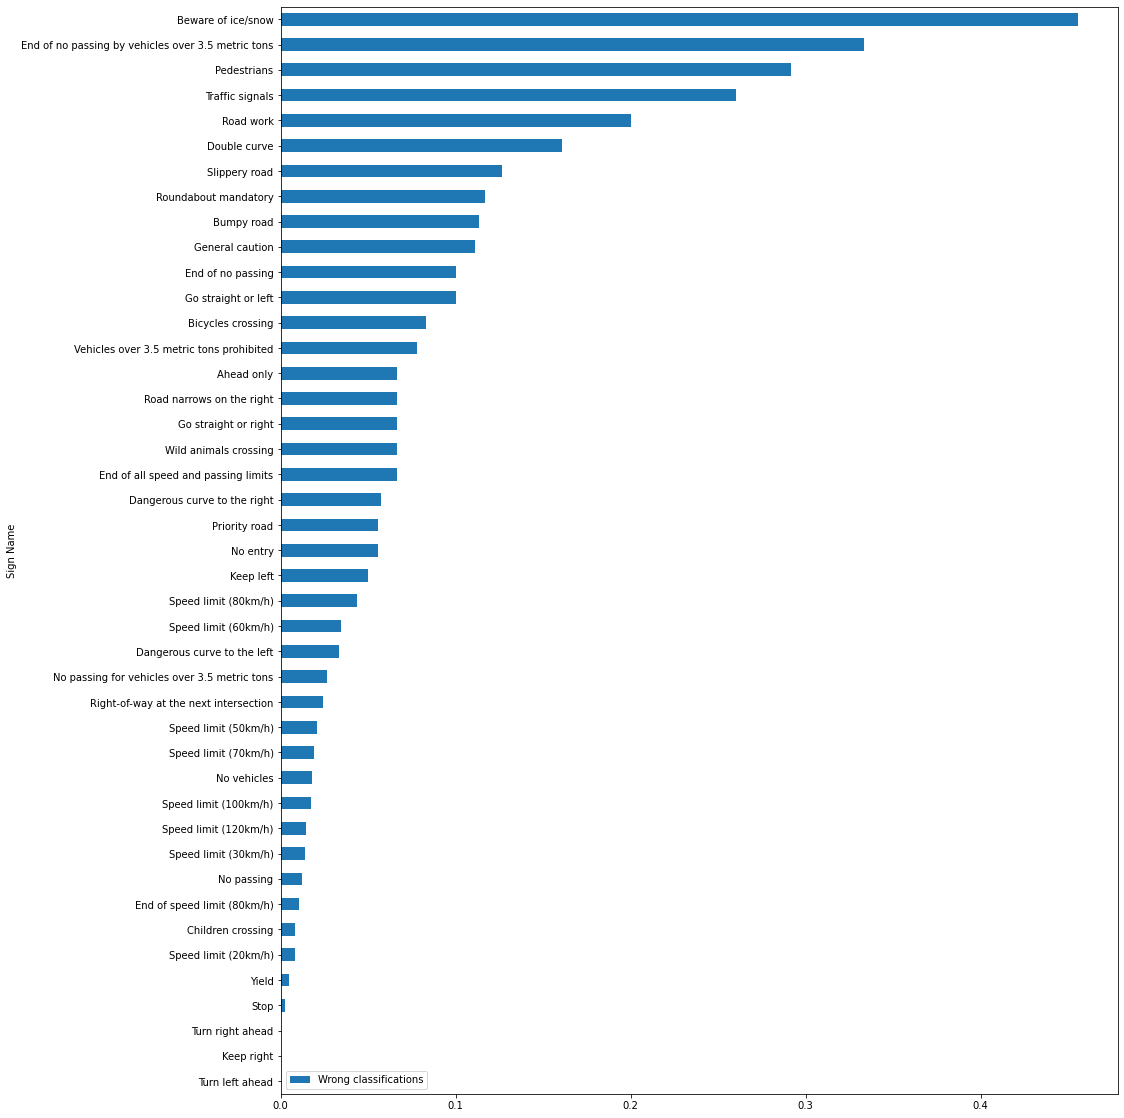

In [41]:
wrong_classifications_weighted = [np.bincount(np.where(np.take(test_y_raw, wrong_classification_indices, axis=0) == id)[0]).sum() / dist_test.iloc[id]
                                  for id in class_ids]
df_wrong_classifications = DataFrame(wrong_classifications_weighted, columns=["Wrong classifications"]).merge(
    DataFrame(classes, columns=["Sign Name"]), left_index=True, right_index=True
).set_index("Sign Name").sort_values(by="Wrong classifications")
df_wrong_classifications.plot.barh(figsize=(15, 20))

Schauen wir uns jeweils die Top 5 besten und schlechtesten Klasssen an.

In [42]:
print(f"Worst 5 classes")
df_wrong_classifications[-5:]

Worst 5 classes


,Wrong classifications
Sign Name,
Road work,0.200000
Traffic signals,0.260000
Pedestrians,0.291667
End of no passing by vehicles over 3.5 metric tons,0.333333
Beware of ice/snow,0.455556


Bei den Top 5 schlechtesten Klassen handelt es sich ausschließlich um komplexe Schilder.
Das erklaert, warum das neuronale Netz nicht so gut darin ist, sie zu erkennen.
Vor allem *beware of ice/snow* faellt dabei auf, da es eine Erkennungsquote von nur knapp ueber
50% hat, was im Vergleich zu den andere Schildern und sogar den andere Top 4 der schlechtest erkannten
Schildern um einiges schlechter ist.
Die Performance dieser schlechtesten Klassen koennte vor allem mit hoeher aufloesenden
Bilder verbessert werden, da mit diesen die Details eines Schildes besser erkannt werden koennen.

In [43]:
print(f"Top 5 classes")
df_wrong_classifications[:5]

Top 5 classes


,Wrong classifications
Sign Name,
Turn left ahead,0.000000
Keep right,0.000000
Turn right ahead,0.000000
Stop,0.002564
Yield,0.004762


Bei den Top 5 beste Klassen handelt es sich um eindeutige und unkomplexe Schilder.
Vor allem die im vorherigen schon besprochenen *turn left ahead* oder *turn right ahead* Schilder
sind vor allem durch ihre Farbe eundeutig. Aehnlich ist es bei dem *stop* oder *yield* Schild, welche
durch ihre aussergewoehnliche Form eindeutig sind.

Jetzt werden noch einmal konkrete Fehlerkennungen angeschaut.

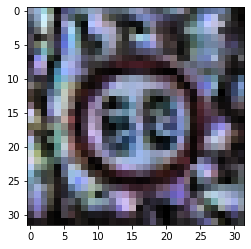

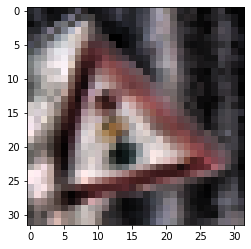

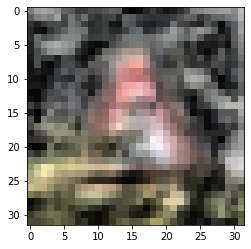

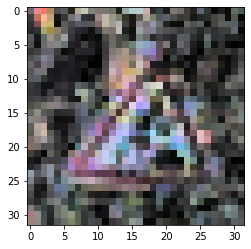

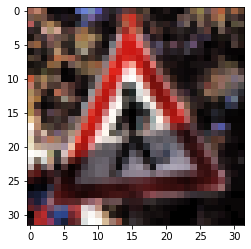

In [44]:
for i in range(5):
    plt.imshow(wrong_classifications[i])
    plt.show()

Wie gut erkennbar ist, sind die Fehlerkennungen in diesen Faellen vor allem einer
schlechten Bildqualitaet zuzuordnen. Vor allem die Geschwindigkeitsbegrenzungen koennte
wohl auch kein Mensch in dieser Qualitaet erkennen.
Auffaellig sind dabei auch Rotationen des Schildes, sowie die Verdeckung durch andere
Objekte oder wie im letzten Fall, von einem Schatten.

Dies sind Sonderfaelle, die nicht oft genug auftreten, damit das neuronale Netz sie ausreichend
gut erkennen kann. Sollte das Ziel sein, auch diese Faelle zu erkennen, wuerden mehr
Trainingsdaten mit genau diesen Faellen benoetig werden.